In [1]:
import json

import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:34, 5852.02it/s]


In [7]:
len(responses)

153499


Посмотрим на пример отзыва:

In [8]:
responses[45]

{'city': 'г. Красноярск',
 'rating_not_checked': False,
 'title': 'Куча смс и непонятные звонки в 8 утра',
 'num_comments': 1,
 'bank_license': 'лицензия № 1460',
 'author': 'ValeriaD',
 'bank_name': 'Восточный Экспресс Банк',
 'datetime': '2015-06-06 09:48:05',
 'text': 'Здравствуйте. Неделю назад я приобрела себе сим-карту Beeline. Как выяснилось позже, она принадлежала какому-то должнику этого банка (пришло несколько сообщений от VOSTALERT, поиск по этому слову нашёл именно Восточный Экспресс Банк). Сообщения выглядят очень по-хамски, но это не имеет отношения к делу. В общем, они, вероятно, передали договор службам взыскания, так что сегодня мне поступило 8 звонков с разных номеров, начиная с 8 утра. Сообщение о том, что договор был передан в службу взыскания, пришло тоже сегодня, но уже в 13:26. В общем, поскольку я отношения к этому банку не имею (и иметь не собираюсь), прошу исключить мой номер из подобных рассылок.',
 'rating_grade': None}

In [4]:
df = pd.DataFrame(responses)
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [65]:
df.describe()

,num_comments,rating_grade,word_count,char_count
count,153499.000000,88658.000000,153499.000000,153499.000000
mean,3.722102,2.153274,237.062743,1554.212790
std,6.695089,1.509953,201.430014,1319.098042
min,0.000000,1.000000,1.000000,23.000000
25%,0.000000,1.000000,111.000000,732.000000
50%,2.000000,1.000000,182.000000,1193.000000
75%,4.000000,3.000000,295.000000,1929.000000
max,406.000000,5.000000,5000.000000,32082.000000


1. Количество отзывов по городам и банкам

In [11]:
# Количество отзывов в разных городах 
feedback_for_city = df.groupby('city').count()['title'].sort_values(ascending=False)
print( f'Количество городов в датасете {len(feedback_for_city)}')
feedback_for_city.head(10)

Количество городов в датасете 5823


city
г. Москва             55354
г. Санкт-Петербург    14342
г. Екатеринбург        2337
г. Новосибирск         2300
г. Нижний Новгород     1976
г. Ростов-на-Дону      1891
г. Самара              1731
г. Челябинск           1507
г. Казань              1440
г. Краснодар           1262
Name: title, dtype: int64

In [12]:
# Количество отзывов в разных банках
feedback_for_bank = df.groupby('bank_name').count()['title'].sort_values(ascending=False)
print( f'Количество банков в датасете {len(feedback_for_bank)}')
feedback_for_bank.head(10)

Количество банков в датасете 670


bank_name
Сбербанк России              26327
Альфа-Банк                   10224
ВТБ 24                        8185
Русский Стандарт              7943
Хоум Кредит Банк              7549
Тинькофф Банк                 5387
Национальный Банк «Траст»     4607
Ренессанс Кредит              3849
Связной Банк                  3775
ОТП Банк                      3237
Name: title, dtype: int64

2.Гистограмы длин отзывов в символах и в словах

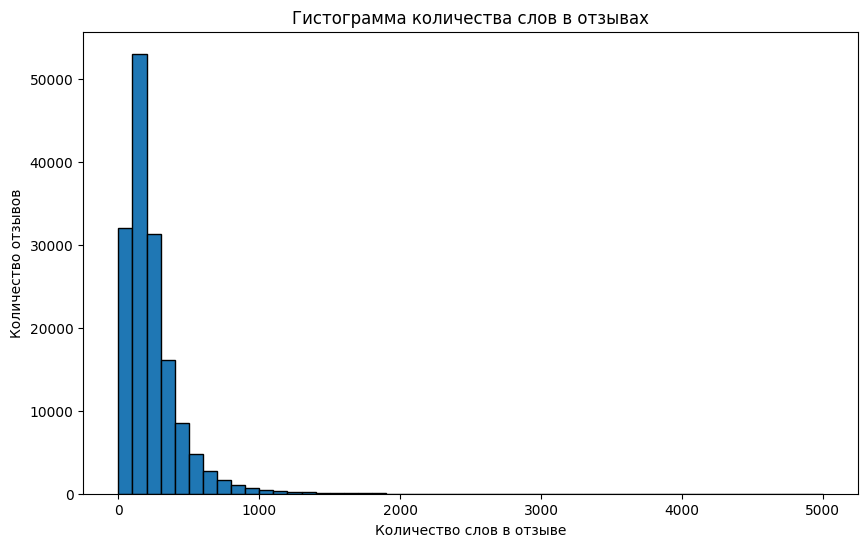

In [13]:
# Посчитаем  количество слов в каждом отзыве
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Построение гистограммы
plt.figure(figsize=(10,6))
df['word_count'].plot(kind='hist', bins=50, edgecolor='black')
plt.title('Гистограмма количества слов в отзывах')
plt.xlabel('Количество слов в отзыве')
plt.ylabel('Количество отзывов')
plt.show()

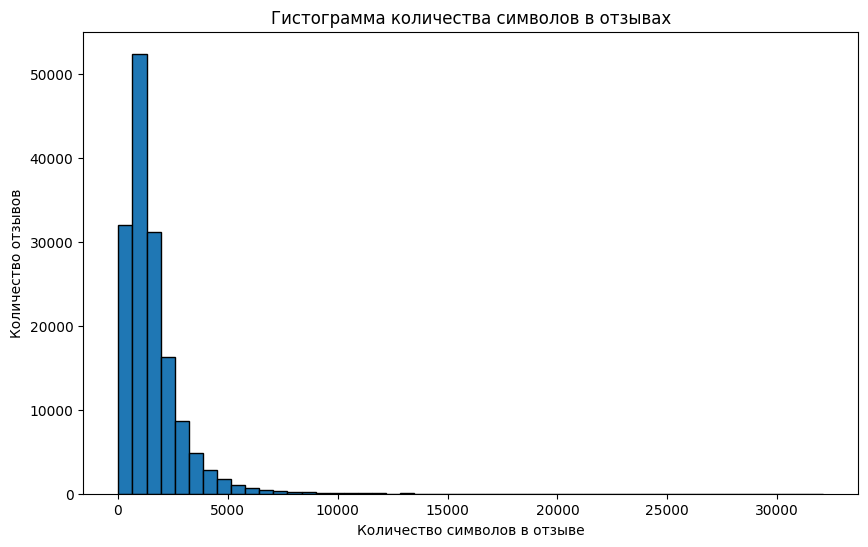

In [14]:
# Поcчитаем количество символов в каждом отзыве
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Построение гистограммы
plt.figure(figsize=(10,6))
df['char_count'].plot(kind='hist', bins=50, edgecolor='black')
plt.title('Гистограмма количества символов в отзывах')
plt.xlabel('Количество символов в отзыве')
plt.ylabel('Количество отзывов')
plt.show()

3 Найдем 10 самых частых слов

In [5]:
# Отберем первые 10000 отзывов
df_reduced = pd.DataFrame(responses[:10000])
df_reduced.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [16]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                10000 non-null  object 
 1   rating_not_checked  10000 non-null  bool   
 2   title               10000 non-null  object 
 3   num_comments        10000 non-null  int64  
 4   bank_license        10000 non-null  object 
 5   author              10000 non-null  object 
 6   bank_name           10000 non-null  object 
 7   datetime            10000 non-null  object 
 8   text                10000 non-null  object 
 9   rating_grade        4150 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 713.0+ KB


In [17]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
from collections import Counter
from nltk.tokenize import word_tokenize
corpus = [token for feedback in df_reduced.text for token in word_tokenize(feedback) if token not in punctuation]
print(len(corpus))
corpus[:10]

2119635


['Добрый',
 'день',
 'Я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по']

In [19]:
# Посчитаем частоту встречаемости слов выведем 10 самых часто встречаемых
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('в', 66119),
 ('и', 56611),
 ('не', 47834),
 ('на', 37085),
 ('что', 34423),
 ('с', 26169),
 ('я', 25483),
 ('по', 20865),
 ('мне', 17420),
 ('банка', 14605)]

In [20]:
from nltk.corpus import stopwords
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [21]:
noise = stopwords.words('russian') +['В','Я','``',"''",'...','И','На','это']+ list(punctuation)

In [22]:
# Посчитаем частоту встречаемости слов  без стоп-слов, выведем 10 самых часто встречаемых
corpus = [token for feedback in df_reduced.text for token in word_tokenize(feedback) if token.lower() not in noise]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банка', 14605),
 ('банк', 10023),
 ('деньги', 6548),
 ('карты', 5866),
 ('карту', 5447),
 ('день', 4630),
 ('кредит', 4136),
 ('года', 3680),
 ('заявление', 3664),
 ('банке', 3453)]

In [23]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

In [24]:
def lemmatize(text, mystem=mystem_analyzer):
    try:
        return "".join(mystem.lemmatize(text)).strip() 
    except:
        return " "
      
def  remove_stoplemmas(text, noise = noise):
    try:
        return " ".join([token for token in text.split() if not token in noise])
    except:
        return ""    
       
def preprocessing(text):
    lemmas = lemmatize(text)
    lemmas = remove_stoplemmas(lemmas)
    return(lemmas)

In [25]:
df_reduced['lemma'] = df_reduced.text.apply(lambda x: preprocessing(x))

In [26]:
# Посчитаем частоту встречаемости лемматезированных слов
corpus = [token for feedback in df_reduced.lemma for token in word_tokenize(feedback) if token.lower() not in noise]
freq_dict = Counter(corpus)
freq_dict.most_common(10)

[('банк', 36785),
 ('карта', 18714),
 ('день', 10001),
 ('кредит', 9710),
 ('деньги', 9478),
 ('сотрудник', 9349),
 ('который', 9097),
 ('клиент', 7789),
 ('счет', 7744),
 ('весь', 7429)]

In [27]:
# Посчитаем частоту встречаемости существительных слов
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

# Функция для извлечения существительных из текста
def get_nouns(text):
    words = text.split()
    # Приведение каждого слова к нормальной форме и фильтрация существительных
    nouns = [morph.parse(word)[0].normal_form for word in words if 'NOUN' in morph.parse(word)[0].tag]
    return nouns


all_nouns = df_reduced['text'].apply(get_nouns).sum()


nouns_freq = Counter(all_nouns)


nouns_freq.most_common(10)


[('банк', 25619),
 ('карта', 12532),
 ('сотрудник', 7850),
 ('деньга', 6775),
 ('кредит', 5913),
 ('сумма', 5537),
 ('счёт', 5374),
 ('отделение', 5354),
 ('день', 5178),
 ('клиент', 4947)]

In [28]:
len(nouns_freq)

14039

### Построим кривые Ципфа и Хипса

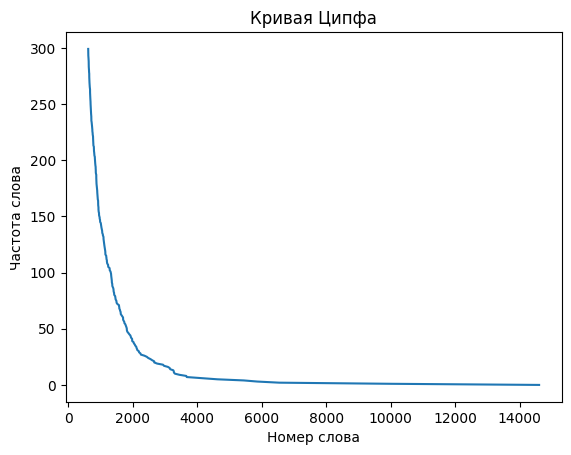

In [29]:
corpus = [token for feedback in df_reduced.text for token in word_tokenize(feedback) if token.lower() not in noise]
freq_dict = Counter(corpus)

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.show()

In [30]:
from tqdm import tqdm

cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df_reduced.iterrows(), total = len(df_reduced)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in noise])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 10000/10000 [00:28<00:00, 355.30it/s]


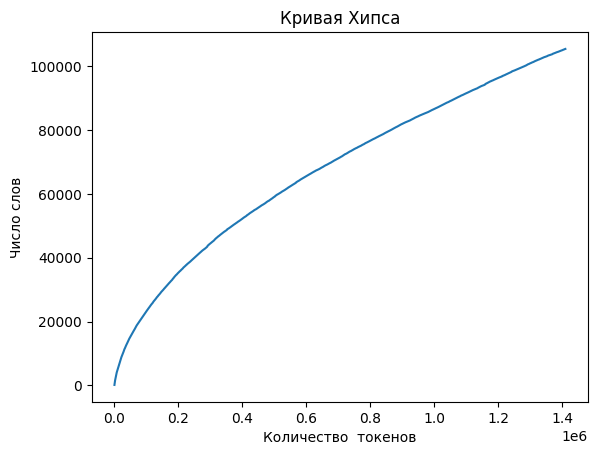

In [31]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.show()

### Оценим встречаемость слов

In [32]:
corpus = [token for feedback in df_reduced.lemma for token in word_tokenize(feedback) if token.lower() not in noise]
freq_dict = Counter(corpus)


In [33]:
print(f"Слово 'сотрудник' встречается {freq_dict['сотрудник']} раз")
print(f"Слово 'клиент' встречается {freq_dict['клиент']} раз")
print()
if freq_dict['сотрудник'] > freq_dict['клиент']:
    print( "сотрудник встречается чаще клиента")
else:
    print( "клиент встречается чаще сотрудника")
print()

print(f"Слово 'мошенничество' встречается {freq_dict['мошенничество']} раз")
print(f"Слово 'доверие' встречается {freq_dict['доверие']} раз")



Слово 'сотрудник' встречается 9349 раз
Слово 'клиент' встречается 7789 раз

сотрудник встречается чаще клиента

Слово 'мошенничество' встречается 219 раз
Слово 'доверие' встречается 151 раз


### В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
df.rating_grade.value_counts()

rating_grade
1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: count, dtype: int64

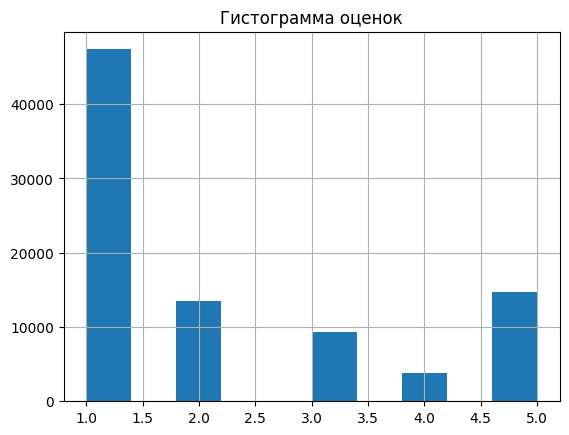

In [36]:
df.rating_grade.hist()
plt.title('Гистограмма оценок')
plt.show()

Будем работать на полном датасете, выборка сделана по рейтинкам отзывов

In [37]:
positive_reviews = df[df['rating_grade'] == 5]['text']
negative_reviews = df[df['rating_grade'] == 1]['text']

In [38]:
positive_lemma = positive_reviews.apply(lambda x: preprocessing(x))

In [39]:
negative_lemma = negative_reviews.apply(lambda x: preprocessing(x))

In [40]:
# Функция для вычисления TF-IDF и вывода ключевых слов и биграмм
def get_key_terms(reviews, ngram_range=(1, 1), max_features=10):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)
    feature_array = tfidf_vectorizer.get_feature_names_out()
    tfidf_sorting = tfidf_matrix.sum(axis=0).getA1().argsort()[::-1]
    top_n = feature_array[tfidf_sorting][:max_features]
    return top_n

In [41]:
# Получаем ключевые слова для положительных отзывов
positive_key_words = get_key_terms(positive_lemma, ngram_range=(1, 1))
positive_key_bigrams = get_key_terms(positive_lemma, ngram_range=(2, 2))

# Получаем ключевые слова для отрицательных отзывов
negative_key_words = get_key_terms(negative_lemma, ngram_range=(1, 1))
negative_key_bigrams = get_key_terms(negative_lemma, ngram_range=(2, 2))


In [42]:
rank = pd.DataFrame({'Positive_key_words': positive_key_words, 'Positive_key_bigrams': positive_key_bigrams, 'Negative_key_words': negative_key_words, 'Negative_key_bigrams': negative_key_bigrams})
rank

,Positive_key_words,Positive_key_bigrams,Negative_key_words,Negative_key_bigrams
0,банк,сотрудник банк,банк,сотрудник банк
1,карта,кредитный карта,карта,какой то
2,весь,интернет банк,деньги,написать заявление
3,очень,клиент банк,день,отделение банк
4,отделение,открывать вклад,то,кредитный карта
5,кредит,какой то,отделение,денежный средство
6,день,следующий день,кредит,что то
7,то,отделение банк,счет,горячий линия
8,клиент,являться клиент,сотрудник,из за
9,который,что то,который,рабочий день


## Тематическое моделирование

In [67]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, lsimodel, ldamodel
from gensim import similarities

In [71]:
texts = [df_reduced.lemma.iloc[i].split() for i in range(len(df_reduced))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [72]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [73]:
%%time
lsi_10= lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: user 28.2 s, sys: 13.7 s, total: 41.9 s
Wall time: 3.91 s


In [74]:
lsi_10.show_topics()

[(0,
  '0.159*"карта" + 0.109*"кредит" + 0.106*"деньги" + 0.100*"сотрудник" + 0.094*"кредитный" + 0.093*"заявление" + 0.093*"ваш" + 0.093*"счет" + 0.092*"сумма" + 0.091*"отделение"'),
 (1,
  '0.254*"звонок" + 0.235*"номер" + 0.206*"ваш" + -0.200*"карта" + -0.189*"вклад" + 0.159*"кредит" + 0.155*"персональный" + 0.150*"телефон" + -0.134*"деньги" + 0.131*"поступать"'),
 (2,
  '-0.434*"вклад" + 0.247*"карта" + -0.202*"договор" + 0.166*"банкомат" + -0.155*"кредит" + -0.155*"ставка" + -0.146*"условие" + -0.132*"страховка" + -0.126*"страхование" + 0.126*"номер"'),
 (3,
  '0.394*"вклад" + -0.234*"кредит" + -0.158*"страховка" + 0.153*"номер" + -0.150*"платеж" + -0.146*"кредитный" + -0.145*"сумма" + -0.144*"погашение" + 0.142*"открывать" + -0.141*"страхование"'),
 (4,
  '0.259*"денежный" + 0.232*"средство" + 0.177*"вклад" + 0.152*"договор" + 0.131*"счет" + -0.127*"заявка" + -0.095*"кредит" + -0.092*"сказать," + 0.092*"персональный" + -0.091*"очень"'),
 (5,
  '0.199*"платеж" + -0.170*"страховани

In [75]:
lda_model = ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [76]:
topics = lda_model.print_topics(num_words=4)

In [77]:
for topic in topics:
    print(topic)

(0, '0.022*"звонок" + 0.020*"номер" + 0.016*"ваш" + 0.014*"банк"')
(1, '0.002*"MOSCOW" + 0.002*"RUS" + 0.001*"RUB" + 0.001*"BEELINE"')
(2, '0.051*"вклад" + 0.013*"открывать" + 0.013*"банк" + 0.013*"вклад,"')
(3, '0.017*"банк" + 0.012*"карта" + 0.007*"который" + 0.007*"деньги"')
(4, '0.019*"банк" + 0.013*"договор" + 0.008*"данный" + 0.008*"денежный"')


In [80]:
# Просмотр ключевых слов для каждой темы
for i, topic in lda_model.show_topics(formatted=False, num_topics=lda_model.num_topics):
    print(f"Тема #{i}:", [word for word, prob in topic])

Тема #0: ['звонок', 'номер', 'ваш', 'банк', 'звонить', 'телефон', 'сотрудник', 'поступать', 'кредит', 'данный']
Тема #1: ['MOSCOW', 'RUS', 'RUB', 'BEELINE', '"Retail', '499', 'авторизация', '272', 'альфабанка', 'микрорайон']
Тема #2: ['вклад', 'открывать', 'банк', 'вклад,', 'вклад.', 'ставка', 'условие', 'процент', 'договор', 'пополнение']
Тема #3: ['банк', 'карта', 'который', 'деньги', 'весь', 'свой', 'сотрудник', 'мочь', 'отделение', 'банк,']
Тема #4: ['банк', 'договор', 'данный', 'денежный', 'кредит', 'заявление', 'кредитный', 'средство', 'сумма', 'который']


2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

In [64]:
df.bank_name.value_counts(normalize=1).head(10)

bank_name
Сбербанк России              0.171513
Альфа-Банк                   0.066606
ВТБ 24                       0.053323
Русский Стандарт             0.051746
Хоум Кредит Банк             0.049179
Тинькофф Банк                0.035095
Национальный Банк «Траст»    0.030013
Ренессанс Кредит             0.025075
Связной Банк                 0.024593
ОТП Банк                     0.021088
Name: proportion, dtype: float64

## Классификация текстов

In [7]:
df_proc = df.loc[df['rating_grade'].isin([1, 5])]

In [8]:
df_proc.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0
76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0
94,г. Чапаевск,False,Некомпетентность сотрудника Сбербанка при пров...,16,лицензия № 1481,usmanovaket,Сбербанк России,2015-06-03 16:00:12,В апреле этого года пришла в отделение сбербан...,1.0


In [9]:
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62100 entries, 19 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city                50366 non-null  object 
 1   rating_not_checked  62100 non-null  bool   
 2   title               62100 non-null  object 
 3   num_comments        62100 non-null  int64  
 4   bank_license        62100 non-null  object 
 5   author              62092 non-null  object 
 6   bank_name           62100 non-null  object 
 7   datetime            62100 non-null  object 
 8   text                62100 non-null  object 
 9   rating_grade        62100 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 4.8+ MB


In [10]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df_proc.text, df_proc.rating_grade)

Обучим модель на униграммах

In [12]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

In [13]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [14]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98     11939
         5.0       0.92      0.94      0.93      3586

    accuracy                           0.97     15525
   macro avg       0.95      0.96      0.96     15525
weighted avg       0.97      0.97      0.97     15525



Получили достаточно высокие метрики. 

Попробуем использовать триграммы

In [15]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

In [16]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [17]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.87      0.93     13475
         5.0       0.54      0.96      0.69      2050

    accuracy                           0.89     15525
   macro avg       0.77      0.92      0.81     15525
weighted avg       0.93      0.89      0.90     15525



Качество на триграммах упало. 

1-ый вариант: tf - idf преобразование
  

In [18]:
vec = TfidfVectorizer()
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.97      0.98     12178
         5.0       0.89      0.97      0.93      3347

    accuracy                           0.97     15525
   macro avg       0.94      0.97      0.95     15525
weighted avg       0.97      0.97      0.97     15525



2-ой вариант: тематические модели LDA 

In [20]:
count_vect = CountVectorizer(max_df=0.95, min_df=2)
lda = LatentDirichletAllocation(n_components=10, random_state=42)

lda_pipeline = Pipeline([
    ('vect', count_vect),
    ('lda', lda)
])

lda_pipeline.fit(x_train)

# Преобразование тренировочных и тестовых данных
x_train_lda = lda_pipeline.transform(x_train)
x_test_lda = lda_pipeline.transform(x_test)

clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(x_train_lda, y_train)

pred = clf.predict(x_test_lda)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94     11860
         5.0       0.86      0.73      0.79      3665

    accuracy                           0.91     15525
   macro avg       0.89      0.85      0.87     15525
weighted avg       0.91      0.91      0.91     15525



Результат получили ниже чем при использовании tf idf, но это возможно связано с тем, что датасет нужно было предобработать перед разделением на тест и трейн, убрать шум в виде пунктуации и стоп-слов